In [22]:
import numpy as np
from gwbench import network
from gwbench import snr
from gwbench import waveform as wfc


import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from scipy.optimize import minimize
import dill
from pycbc import conversions as conv


from astropy.cosmology import Planck18, z_at_value
import astropy.units as u

In [23]:
import matplotlib


font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)


In [43]:
def get_network_response(inj_params, network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V'], approximant='IMRPhenomXAS', deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi', cond_num=1e25):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name = 'lal_bbh' # lal_hybrid....
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

    # pick the desired frequency range
    f_min = 5.
    f_max = 512.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    
    # # compute the WF polarizations
    net.calc_wf_polarizations()
    # # compute the WF polarizations and their derivatives
    net.calc_wf_polarizations_derivs_num()

    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()
    # compute the detector responses and their derivatives
    net.calc_det_responses_derivs_num()

    # calculate the network and detector SNRs
    net.calc_snrs()

    

    # # calculate the network and detector Fisher matrices, condition numbers,
    # # covariance matrices, error estimates, and inversion errors
    net.calc_errors(cond_sup=cond_num)

    wf_true = wfc.Waveform(wf_model_name = 'lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
    net.calc_cutler_vallisneri_bias(wf=wf_true)

    return net


For given 'true' and 'approximate' waveforms $h_{TR}$ and $h_{AP}$, the systematic error due to waveform inaccuracy on the parameter $\theta^i$ is given by:
$$ \Delta \theta^i = (\Gamma_{AP}^{-1})^{ij} \quad  \Sigma_{D=1}^{N_{det}}  (\partial_j (h_{AP})_D | (h_{TR})_D - (h_{AP})_D)$$


We will assume that IMRPhenomXAS is $h_{TR}$ (net1) and IMRPhenomD is $h_{AP}$ (net2).


In [44]:
name = 'GW150914'

# Detector frame
Mc = 30.8 #M_sol
m1 = 38.7 #M_sol
m2 = 32.5 #M_sol
DL = 440 #Mpc
q = m2/m1

chi_eff = -0.04
chi_p = 0.32
a1 = 0.26
a2 = 0.32

# Mc = conv.mchirp_from_mass1_mass2(m1, m2)
eta = conv.eta_from_mass1_mass2(m1, m2)

# set the injection parameters
inj_params = {
    'Mc':    Mc,
    'eta':   eta,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': a1,
    'chi2z': a2,
    'DL':    DL,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0
    }


deriv_symbs_string = 'Mc eta DL chi1z chi2z iota ra dec psi'
param_list = deriv_symbs_string.split()

network_dict = {
        'aLIGO':    ['aLIGO_H','aLIGO_L','V+_V'],
        'A+':       ['A+_H', 'A+_L','A+_V'],
        'Voyager':  ['Voyager-CBO_H', 'Voyager-CBO_L', 'Voyager-CBO_V'],
        '3G':       ['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
        }

network_key = '3G'

network_spec = network_dict[network_key]

# Compute Networks from gwbench

In [45]:
net1 = get_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomXAS', cond_num=1e25)

2023-06-05 10:36:02,181 - Network - INFO : Polarizations calculated.
2023-06-05 10:36:02,182 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-06-05 10:36:02,185 - Network - INFO : Polarizations calculated.
2023-06-05 10:36:02,883 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-06-05 10:36:02,911 - Network - INFO : PSDs loaded.
2023-06-05 10:36:02,913 - Network - INFO : Antenna patterns and LPFs loaded.
2023-06-05 10:36:02,925 - Network - INFO : Detector responses calculated.
2023-06-05 10:36:02,926 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-06-05 10:36:02,926 - Network - INFO :    CE-40_C
2023-06-05 10:36:03,449 - Network - INFO :    CE-20_S
2023-06-05 10:36:03,964 - Network - INFO :    ET_ET1
2023-06-05 10:36:04,478 - Network - INFO :    ET_ET2
2023-06-05 10:36:05,003 - Network - INFO :    ET_ET3
2023-06-05 10:36:05,518 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-06-05 1

## Get approx net

In [46]:
net2 = get_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomD', cond_num=1e25)

2023-06-05 10:36:05,700 - Network - INFO : Polarizations calculated.
2023-06-05 10:36:05,701 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-06-05 10:36:05,704 - Network - INFO : Polarizations calculated.
2023-06-05 10:36:06,429 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-06-05 10:36:06,456 - Network - INFO : PSDs loaded.
2023-06-05 10:36:06,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-06-05 10:36:06,468 - Network - INFO : Detector responses calculated.
2023-06-05 10:36:06,468 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-06-05 10:36:06,469 - Network - INFO :    CE-40_C
2023-06-05 10:36:06,993 - Network - INFO :    CE-20_S
2023-06-05 10:36:07,516 - Network - INFO :    ET_ET1
2023-06-05 10:36:08,032 - Network - INFO :    ET_ET2
2023-06-05 10:36:08,549 - Network - INFO :    ET_ET3
2023-06-05 10:36:09,064 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-06-05 1

# Perform Cutler-Vallisneri with (IMRPhenomXAS, IMRPhenomD) and 3G network

In [27]:
net1.inj_params

{'Mc': 30.8,
 'eta': 0.248,
 'chi1x': 0,
 'chi2x': 0,
 'chi1y': 0,
 'chi2y': 0,
 'chi1z': 0.5,
 'chi2z': 0.5,
 'DL': 440,
 'tc': 0,
 'phic': 0,
 'iota': 1.0471975511965976,
 'ra': 1.0471975511965976,
 'dec': 1.0471975511965976,
 'psi': 1.0471975511965976,
 'gmst0': 0}

In [28]:
# Calculate the Theoretical Bias in Parameters based on Cutler-Vallisneri formalism

def compute_wf_bias(net1, net2, param_list, lams=None, inj_params=None):
    inner_prod = np.zeros(len(param_list))
	
    cov_ap = net2.cov

    for d in range(len(net2.detectors)):
        del_h_ap_all = net2.detectors[d].del_hf
        del_params_j = list(del_h_ap_all.keys())
	
        h_tr = net1.detectors[d].hf
        h_ap = net2.detectors[d].hf
        psd = net2.detectors[d].psd
        freq_range = net2.detectors[d].f
        df = freq_range[1] - freq_range[0]

        for j, parameter_j in enumerate(del_params_j):
            del_h_ap_j = del_h_ap_all[parameter_j]
            # Inner Product
            inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
    print(inner_prod)
    return np.matmul(cov_ap, inner_prod)	

In [29]:
param_list = deriv_symbs_string.split()
errors_th = compute_wf_bias(net1, net2, param_list)
print(param_list)
print(errors_th/list(net2.errs.values()))

[ 1.82796832e+06  1.67212202e+07  1.10892038e+04  4.26427527e+06
  2.81535522e+06  5.54216564e+06  1.89513618e+06 -5.92144761e+05
 -1.14089911e+06]
['Mc', 'eta', 'DL', 'chi1z', 'chi2z', 'iota', 'ra', 'dec', 'psi']
[[ 327.10544211  404.99580581 1145.69682656 -460.71486     520.62030277
   -10.02699398  -24.28583649  -29.32837833  -53.9753628 ]]


# Compute Cutler Vallsineri Bias the GWBENCH Way 

In [30]:
# from gwbench import Waveform
from gwbench import waveform as wfc

wf_true = wfc.Waveform(wf_model_name = 'lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})

# wf_true = waveform(wf_model_name=wf_model_name_true, wf_other_var_dic=wf_other_var_dic_true, user_waveform=user_waveform_true)
net2.calc_cutler_vallisneri_bias(wf=wf_true)
print(net2.cutler_vallisneri_overlap_vec)
net2.cutler_vallisneri_bias/list(net2.errs.values())


[ 1.82811540e+06  1.67212679e+07  1.10848534e+04  4.26421538e+06
  2.81530827e+06  5.54007444e+06  1.89306073e+06 -5.92576799e+05
 -1.13930949e+06]


matrix([[ 328.22125296,  405.00309518, 1145.34251114, -460.7307303 ,
          520.73092917,   -9.99446018,  -24.60291819,  -29.89076959,
          -52.41774584]])

## Check if our answers agree

In [31]:
100*(errors_th - net2.cutler_vallisneri_bias)

matrix([[-3.06659045e-02, -1.44392471e-04,  2.32322586e+01,
          2.86097837e-03, -1.90077298e-02, -3.95196929e-03,
          6.73622084e-03,  3.18880237e-02, -1.75140328e-01]])

All the biases agree to within 2%.

# Construct Hybrid Waveform

In [28]:
def get_hybrid_network_response(inj_params, network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V'], approximant1='IMRPhenomXAS', approximant2='IMRPhenomD', hybr=0.5,
                                deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi', cond_num=1e25):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name =  'lal_hybrid_bbh'
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name, wf_other_var_dic = {'approximant1': approximant1,
                                                       'approximant2': approximant2
                                                       })

    # pick the desired frequency range
    f_min = 5.
    f_max = 512.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    
    # # compute the WF polarizations
    net.calc_wf_polarizations()
    # # compute the WF polarizations and their derivatives
    net.calc_wf_polarizations_derivs_num()

    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()
    # compute the detector responses and their derivatives
    net.calc_det_responses_derivs_num()

    # calculate the network and detector SNRs
    net.calc_snrs()

    

    # # calculate the network and detector Fisher matrices, condition numbers,
    # # covariance matrices, error estimates, and inversion errors
    net.calc_errors(cond_sup=cond_num)

    # # calculate the 90%-credible sky area (in deg)
    # net.calc_sky_area_90()

    # compute the cutler-vallisneri bias with respect to the approximant1 waveform model
    wf_true = wfc.Waveform(wf_model_name = 'lal_bbh', wf_other_var_dic = {'approximant': approximant1})
    net.calc_cutler_vallisneri_bias(wf=wf_true)

    return net


In [71]:
inj_params = {
    'Mc':    Mc,
    'eta':   eta,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': a1,
    'chi2z': a2,
    'DL':    DL,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0,
    'hybr': 0.998
    }

deriv_symbs_string = 'Mc eta DL chi1z chi2z iota ra dec psi'

In [72]:
net_hybr = get_hybrid_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant1='IMRPhenomXAS', approximant2='IMRPhenomD', cond_num=1e25)

2023-06-05 10:41:36,790 - Network - INFO : Polarizations calculated.
2023-06-05 10:41:36,791 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-06-05 10:41:36,798 - Network - INFO : Polarizations calculated.
2023-06-05 10:41:37,709 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-06-05 10:41:37,739 - Network - INFO : PSDs loaded.
2023-06-05 10:41:37,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-06-05 10:41:37,766 - Network - INFO : Detector responses calculated.
2023-06-05 10:41:37,766 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-06-05 10:41:37,767 - Network - INFO :    CE-40_C
2023-06-05 10:41:38,468 - Network - INFO :    CE-20_S
2023-06-05 10:41:39,111 - Network - INFO :    ET_ET1
2023-06-05 10:41:39,764 - Network - INFO :    ET_ET2
2023-06-05 10:41:40,410 - Network - INFO :    ET_ET3
2023-06-05 10:41:41,064 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-06-05 1

In [73]:
np.array(net_hybr.cutler_vallisneri_bias)[0]

array([ 0.00170152, -0.00050665, -0.08806367,  0.00303913,  0.00051008,
       -0.00051576,  0.00020432, -0.00021867,  0.00914618])

In [77]:
net_hybr.snr

1659.2238030649646

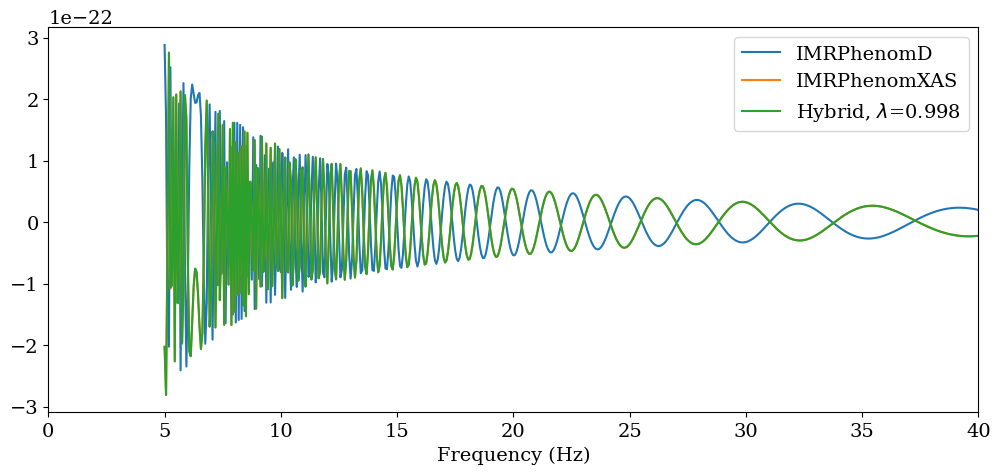

In [74]:
f, ax= plt.subplots(nrows=1, figsize=(12,5)) 

ax.plot(net1.f, np.real(net2.hfp), label="IMRPhenomD")
ax.plot(net1.f, np.real(net1.hfp), label="IMRPhenomXAS")
ax.plot(net1.f, np.real(net_hybr.hfp), label=f"Hybrid, $\lambda$={net_hybr.inj_params['hybr']}")

ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(0, 40)
ax.legend()


0.001701517482850301
hybrid bias 3.246 sigma


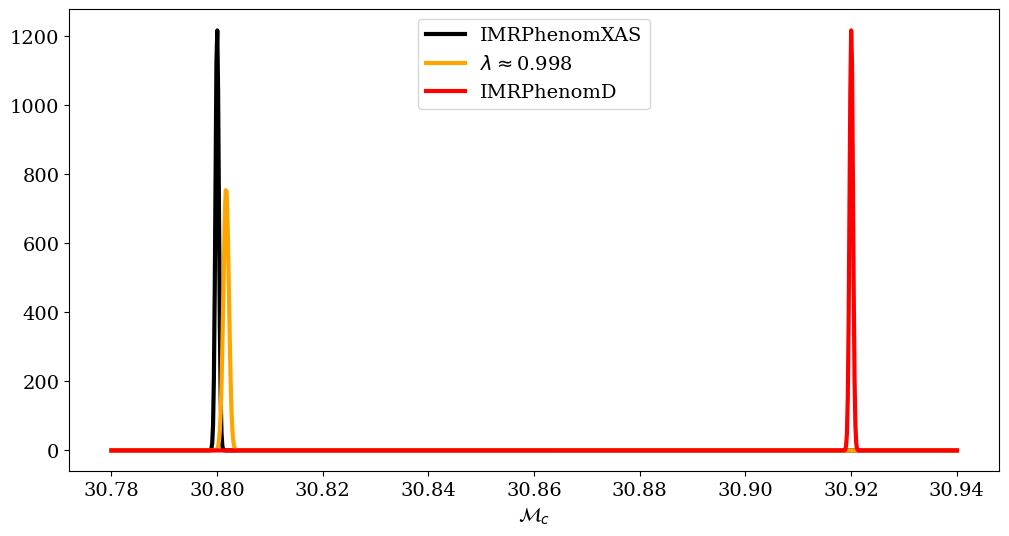

In [76]:
from scipy.stats import norm

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

mc_inj = net1.inj_params["Mc"]
stat_err = net2.errs["Mc"]
bias = np.array(net2.cutler_vallisneri_bias)[0][0]

# print(mc_inj)
# print(bias)

mc = np.linspace(mc_inj-0.02, mc_inj+bias+0.02, 1000)

plt.plot(mc, norm.pdf(mc, mc_inj, stat_err), lw=3, color='k', label="IMRPhenomXAS")

hybr_bias = np.array(net_hybr.cutler_vallisneri_bias)[0][0]
print(hybr_bias)
print(f"hybrid bias {hybr_bias/net_hybr.errs['Mc']:.3f} sigma")

plt.plot(mc, norm.pdf(mc, mc_inj+hybr_bias, net_hybr.errs['Mc']),lw=3, color='orange', label=f"$\lambda \\approx${net_hybr.inj_params['hybr']:.3f}")

plt.plot(mc, norm.pdf(mc, mc_inj+bias, stat_err),lw=3, color='r', label="IMRPhenomD")

# plt.axvline(x=mc_inj, ymin=0.05, color='k', ls='--')
# plt.axvline(x=mc_inj+0.103,  ymin=0.05, color='orange', ls='--')
# plt.axvline(x=mc_inj+bias,  ymin=0.05, color='r', ls='--')

# plt.semilogy()
plt.xlabel("$\mathcal{M}_{c}$")
# plt.title(net1.inj_params["name"])
plt.legend()
plt.show()

# Plot Bias Across Parameters

In [370]:
def plot_bias(nets, param_list, figsize=(8,20)):

    f, ax= plt.subplots(nrows=len(param_list), ncols=1,  figsize=figsize) 
    ax = list(ax)


    for i, param in enumerate((param_list)):
        for net_ap in nets:
            mu = net_ap.inj_params[param]
            sigma = net_ap.errs[param]
            bias = np.array(net_ap.cutler_vallisneri_bias)[0][i]

            low = mu -100*sigma - bias
            high = mu +100*sigma + bias
            x = np.linspace(low, high, 10000)

            stat_est = stats.norm.pdf(x, mu+bias, sigma)
            stat_est = stat_est/ np.max(stat_est)

            try:
                lam = net_ap.inj_params['hybr']
            except:
                lam = 0.0

            ax[i].plot(x, stat_est, label=f"Approximate ($\lambda$={lam:.2f})")
        
        theory_est = stats.norm.pdf(x, mu, sigma)
        theory_est = theory_est/np.max(theory_est)
        ax[i].plot(x, theory_est, label=f"True (IMRPhenomXAS)")
        
        if i==0:
            ax[i].legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=14)

        
        # ax[i].set_xlim(0.5*mu, mu+0.5*mu)
        ax[i].set_xlabel(param, fontsize=20)

    plt.suptitle("Systematic Bias b/w IMRPhenomXAS and Approximate Model", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

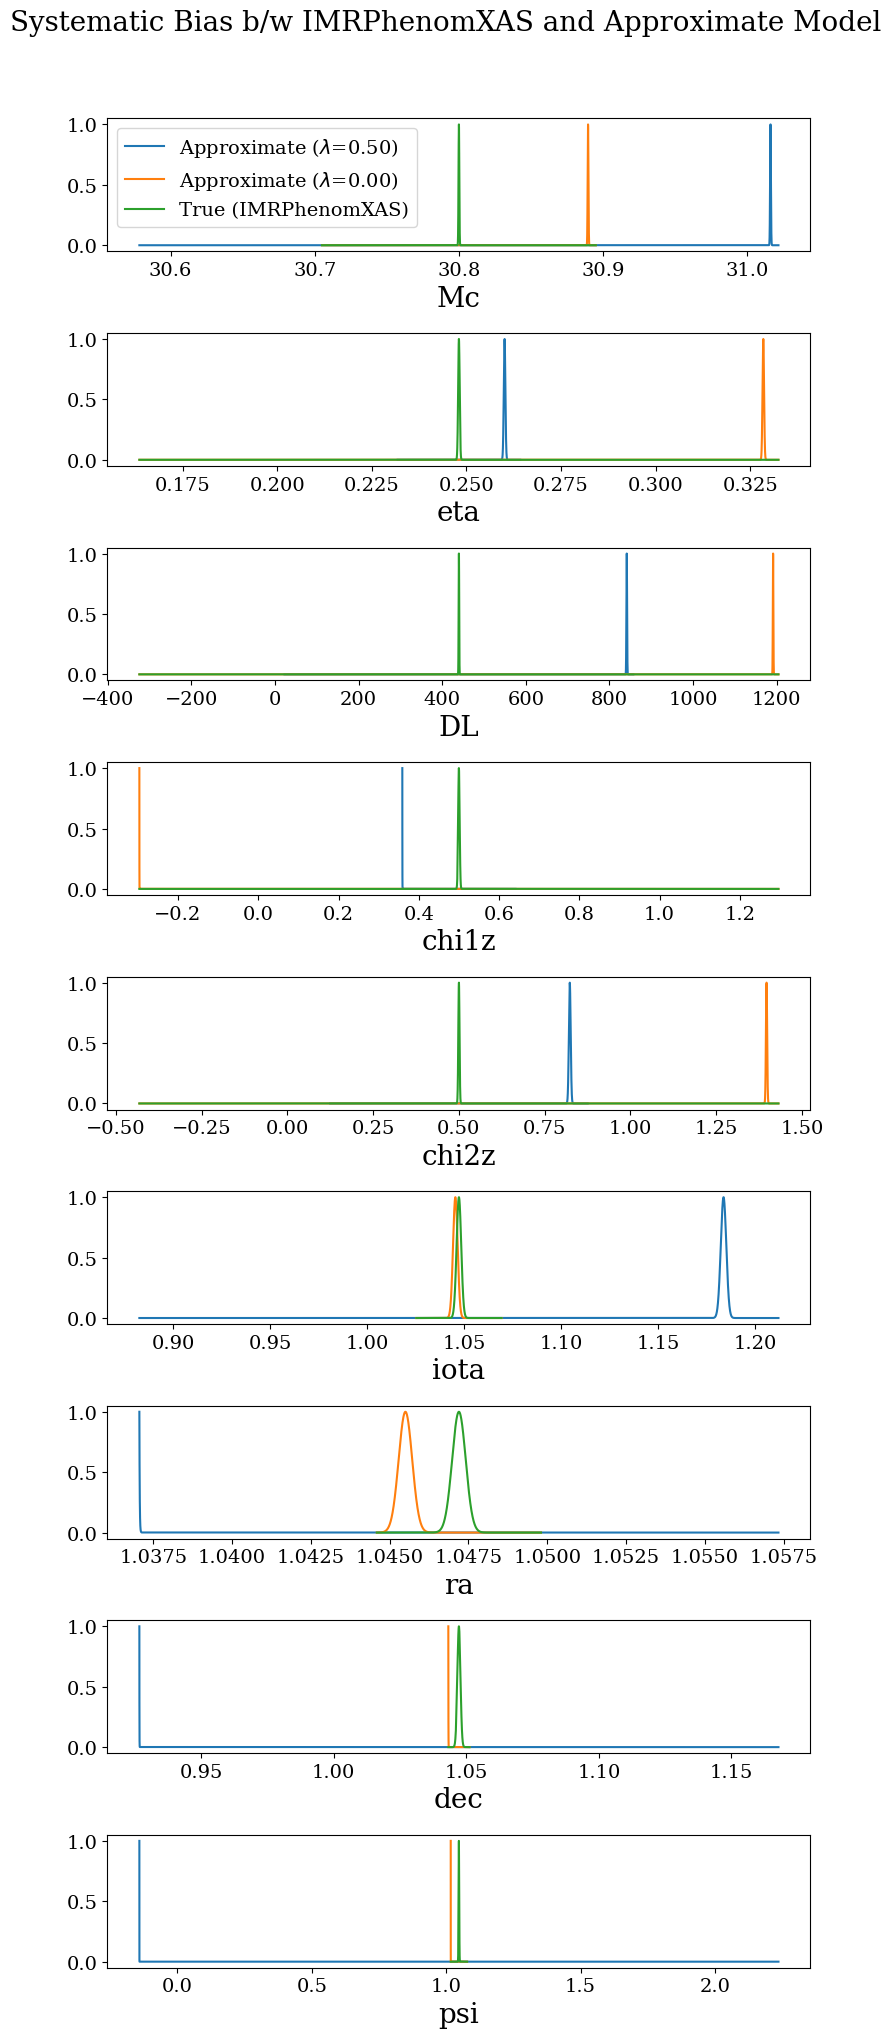

In [368]:
plot_bias([net2_hybrid, net2], param_list)

In [121]:
lams = np.linspace(0.97, 1.0, 10)
hybrid_nets = []
for lam in lams:
    inj_params['hybr'] = lam
    net = get_hybrid_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant1='IMRPhenomXAS', approximant2='IMRPhenomD', cond_num=1e25)
    hybrid_nets.append(net)

2023-05-29 13:41:45,618 - Network - INFO : Polarizations calculated.
2023-05-29 13:41:45,618 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-05-29 13:41:45,625 - Network - INFO : Polarizations calculated.
2023-05-29 13:41:46,461 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-05-29 13:41:46,492 - Network - INFO : PSDs loaded.
2023-05-29 13:41:46,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-05-29 13:41:46,519 - Network - INFO : Detector responses calculated.
2023-05-29 13:41:46,519 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-05-29 13:41:46,520 - Network - INFO :    CE-40_C
2023-05-29 13:41:47,155 - Network - INFO :    CE-20_S
2023-05-29 13:41:47,794 - Network - INFO :    ET_ET1
2023-05-29 13:41:48,419 - Network - INFO :    ET_ET2
2023-05-29 13:41:49,045 - Network - INFO :    ET_ET3
2023-05-29 13:41:49,674 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-05-29 1

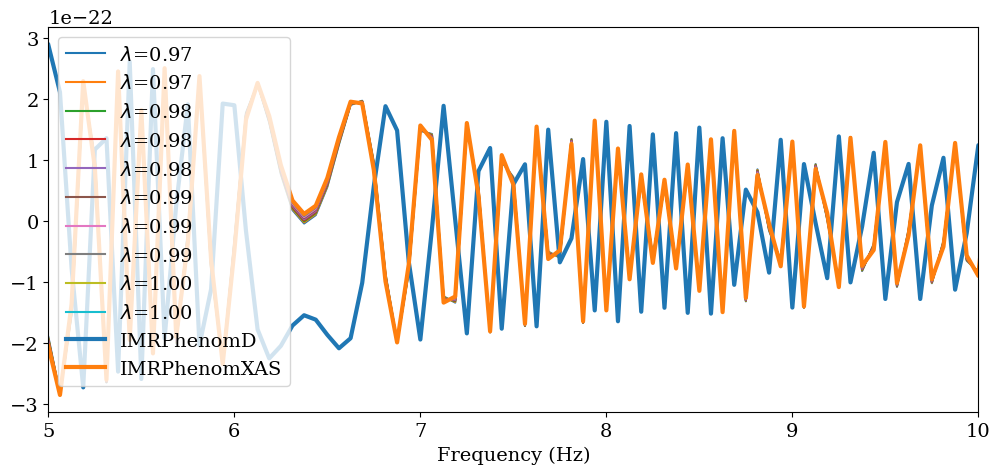

In [122]:
f, ax= plt.subplots(nrows=1, figsize=(12,5)) 


for net_ap in hybrid_nets:
    ax.plot(net_ap.f, np.real(net_ap.hfp), label=f"$\lambda$={net_ap.inj_params['hybr']:.2f}")

ax.plot(net1.f, np.real(net2.hfp), lw=3, label="IMRPhenomD")
ax.plot(net1.f, np.real(net1.hfp), lw=3, label="IMRPhenomXAS")

ax.set_xlabel("Frequency (Hz)")
ax.set_xlim(5, 10)
ax.legend()


In [123]:
plot_bias(hybrid_nets[::3], param_list)

NameError: name 'plot_bias' is not defined

In [124]:
def plot_bias_sig(nets, param_list, figsize=(10,20)):

    f, ax= plt.subplots(nrows=len(param_list), ncols=1,  figsize=figsize) 
    ax = list(ax)


    for i, param in enumerate((param_list)):
        for net_ap in nets:
            mu = net_ap.inj_params[param]
            sigma = net_ap.errs[param]
            bias = np.array(net_ap.cutler_vallisneri_bias)[0][i]
        
            try:
                lam = net_ap.inj_params['hybr']
            except:
                lam = 0.0

            ax[i].scatter(lam, np.abs(bias/sigma), label=f"Approximate ($\lambda$={lam:.2f})")
    
        
        if i==0:
            ax[i].legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)

        
        ax[i].set_xlabel(param, fontsize=20)

    plt.suptitle("Bias Significance b/w IMRPhenomXAS and Approximate Model", y=1.02, fontsize=20)
    # plt.tight_layout()
    plt.show()

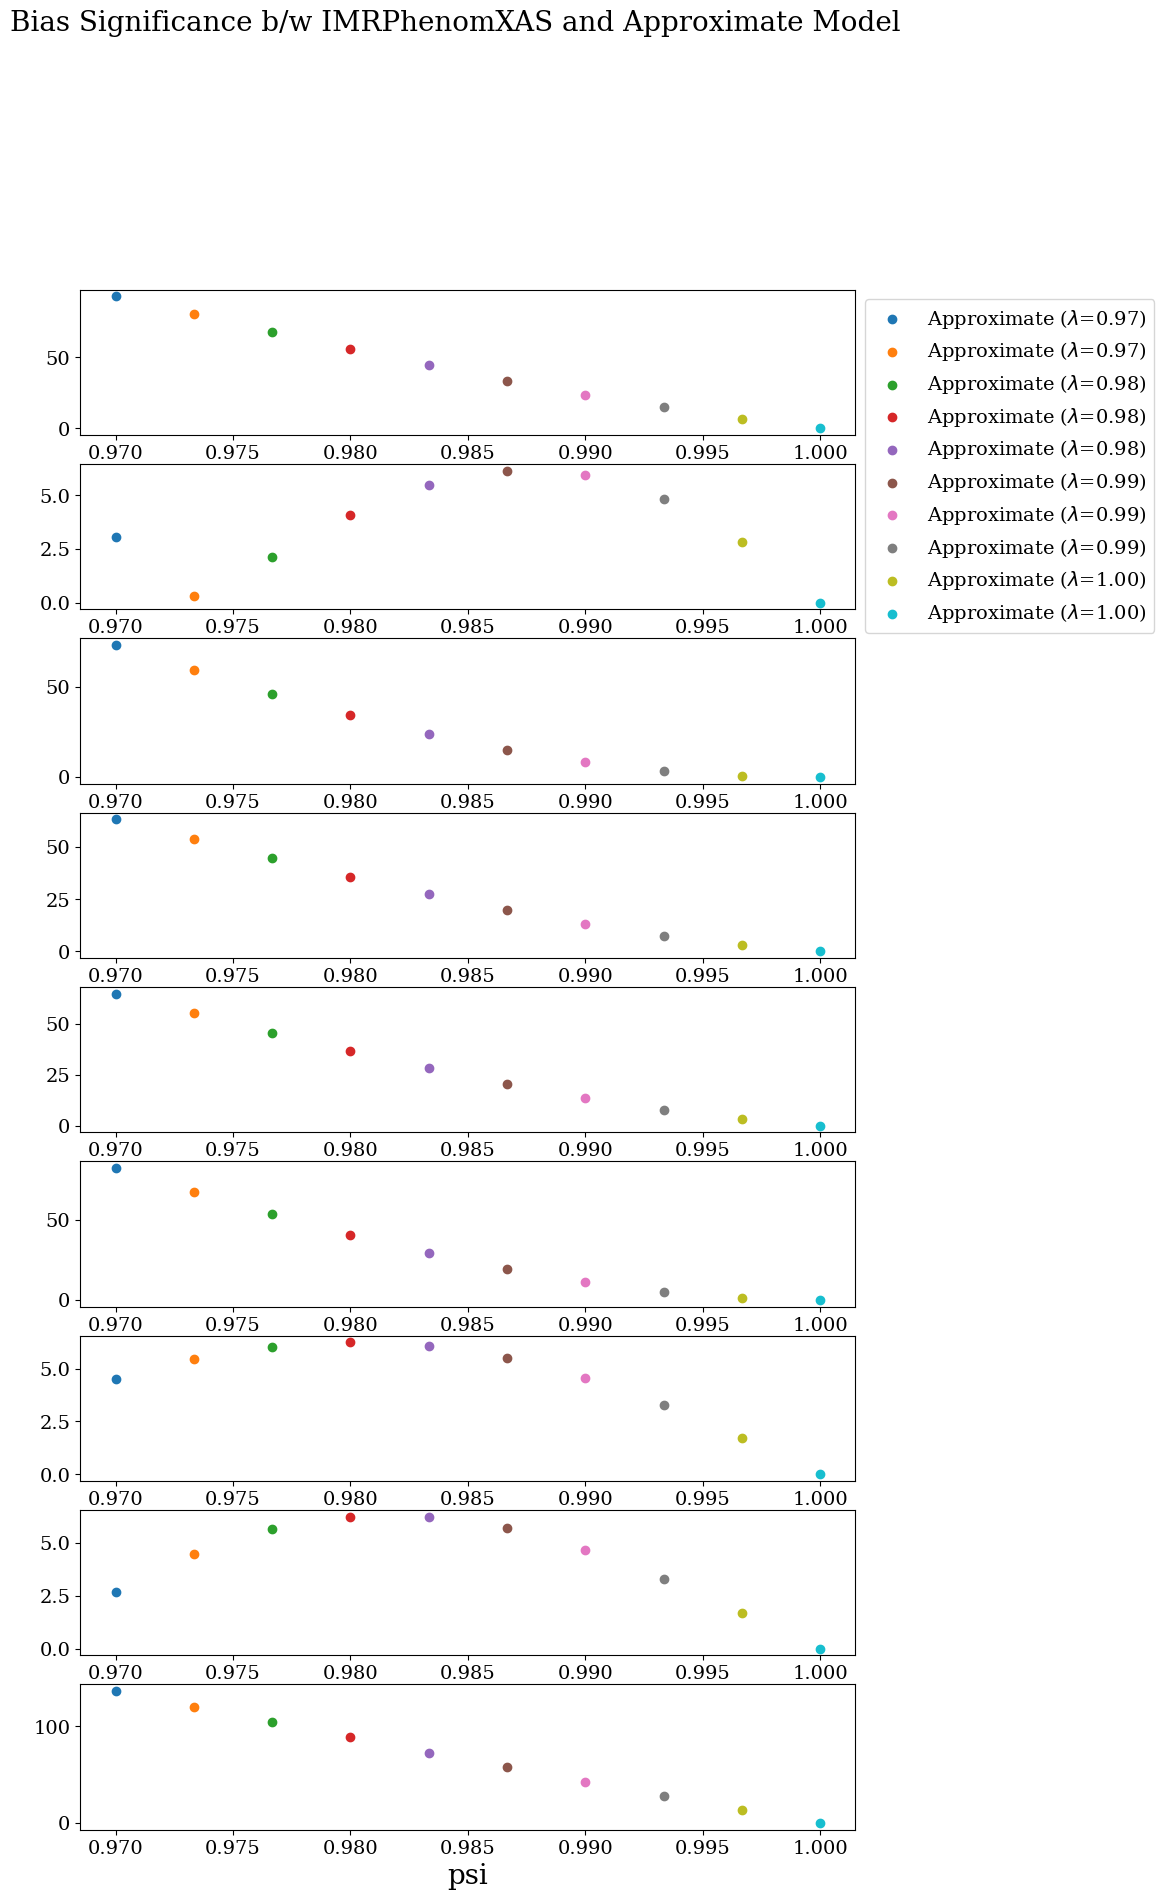

In [125]:
plot_bias_sig(hybrid_nets[:], param_list)

In [49]:
np.array(net2_hybrid.cutler_vallisneri_bias)[0]

array([ 2.16517087e-01,  1.01941561e-02,  4.06978617e+02, -1.67806997e-01,
        3.00929909e-01,  1.33115245e-01, -2.29341295e-02, -1.27943503e-01,
       -1.18380838e+00])

# Compute PyCBC Mismatch

In [78]:
def get_waveform(inj_params, network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V'], approximant='IMRPhenomXAS', deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi', cond_num=1e25):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name = 'lal_bbh' # lal_hybrid....
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

    # pick the desired frequency range
    f_min = 5.
    f_max = 512.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    
    # # compute the WF polarizations
    net.calc_wf_polarizations()

    return net


In [79]:
# Calculate Faithfulness using PyCBC
from gwbench import waveform as wfc
from pycbc.types import FrequencySeries
from pycbc.filter import match

net_true = get_waveform(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomXAS', cond_num=1e25)


2023-06-05 10:44:17,617 - Network - INFO : Polarizations calculated.


In [83]:
delta_f = net_hybr.f[1] - net_hybr.f[0]
psd = FrequencySeries(net_hybr.detectors[0].psd, delta_f=delta_f) # caluclate mismatch using any one detector PSD
   
# make sure that the detector and waveform frequency ranges overlap
freq_mask = np.in1d(net_hybr.f, net_hybr.detectors[0].f, assume_unique=True)

hp1_pyc = FrequencySeries(net_true.hfp[freq_mask], delta_f=delta_f)
hp2_pyc = FrequencySeries(net_hybr.hfp[freq_mask], delta_f=delta_f)


full_faith, index = match(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net_hybr.f[0], high_frequency_cutoff=net_hybr.f[-1])
1-full_faith

3.637110941534516e-06

In [62]:
file='test.npz'
np.savez(file, inj_params = net_hybr.inj_params, errs=net_hybr.errs, cv_bias=net_hybr.cutler_vallisneri_bias, faith=full_faith)
data = np.load(file, allow_pickle=True)

print(data['errs'].item())
print(data['faith'])

{'Mc': 0.00028048683, 'eta': 0.0002037995, 'DL': 0.789174, 'chi1z': 0.0024319345, 'chi2z': 0.002579156, 'iota': 0.0014278761, 'ra': 0.00020956043, 'dec': 0.00047502533, 'psi': 0.001149691}
0.995752042227934


In [7]:
net1.deriv_symbs_string

'Mc eta DL chi1z chi2z iota ra dec psi'